Librairies

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib 
import xgboost as xgb
from sklearn.metrics import classification_report

Import data

In [17]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
df = pd.concat([train, test], ignore_index=True)

In [41]:
data = df.copy()

# Sélection des colonnes qui nous intéressent
data = data[['Etiquette_DPE','Etiquette_GES','Surface_habitable_logement','Conso_5_usages/m²_é_finale','Hauteur_sous-plafond','Conso_5_usages_é_finale_énergie_n°2','Type_bâtiment',
             'Classe_altitude','Qualité_isolation_enveloppe','Qualité_isolation_murs','Qualité_isolation_menuiseries','N°_département_(BAN)']]

# On enlève valeurs aberrantes
data = data[data["Surface_habitable_logement"]<=100000]
data = data[data['Conso_5_usages/m²_é_finale']<=100000]
data = data[data['Hauteur_sous-plafond'] < 10]

data

,Etiquette_DPE,Etiquette_GES,Surface_habitable_logement,Conso_5_usages/m²_é_finale,Hauteur_sous-plafond,Conso_5_usages_é_finale_énergie_n°2,Type_bâtiment,Classe_altitude,Qualité_isolation_enveloppe,Qualité_isolation_murs,Qualité_isolation_menuiseries,N°_département_(BAN)
0,D,C,220.8,171.9,2.9,10676.1,appartement,inférieur à 400m,insuffisante,insuffisante,bonne,25
1,F,C,83.5,221.0,2.5,8678.1,maison,inférieur à 400m,insuffisante,insuffisante,moyenne,44
2,E,B,68.0,130.5,2.5,NaN,maison,inférieur à 400m,insuffisante,insuffisante,insuffisante,35
3,C,C,47.5,162.6,2.5,2576.8,appartement,NaN,insuffisante,insuffisante,moyenne,44
4,E,E,142.5,303.8,2.8,852.8,maison,inférieur à 400m,insuffisante,insuffisante,insuffisante,28
...,...,...,...,...,...,...,...,...,...,...,...,...
2499995,G,C,82.7,273.0,2.5,NaN,maison,inférieur à 400m,insuffisante,insuffisante,insuffisante,06
2499996,D,B,94.7,94.0,2.6,NaN,maison,inférieur à 400m,bonne,bonne,très bonne,06
2499997,E,B,27.5,113.0,2.5,NaN,appartement,inférieur à 400m,très bonne,bonne,moyenne,80
2499998,D,B,28.8,106.0,2.5,NaN,appartement,inférieur à 400m,bonne,insuffisante,bonne,56


In [42]:
data['Etiquette_DPE'].value_counts()

Etiquette_DPE
D    799988
C    579231
E    565344
F    268560
G    187262
B     58873
A     12405
Name: count, dtype: int64

In [43]:
# Choisissez la catégorie cible et le nombre de lignes à supprimer
categorie_cible = 'D'
nombre_a_supprimer = 200000

# Trouver les index des lignes avec la catégorie cible
indexes_a_supprimer = data[data['Etiquette_DPE'] == categorie_cible].index

# Si vous voulez supprimer un nombre spécifique de lignes
if len(indexes_a_supprimer) > nombre_a_supprimer:
    indexes_a_supprimer = indexes_a_supprimer[:nombre_a_supprimer]

# Supprimer les lignes
data = data.drop(indexes_a_supprimer)

# Afficher le DataFrame mis à jour
print(data['Etiquette_DPE'].value_counts())

Etiquette_DPE
D    599988
C    579231
E    565344
F    268560
G    187262
B     58873
A     12405
Name: count, dtype: int64


Traitement data

In [44]:
# Séparer les variables numériques
numerical_vars = data.select_dtypes(include=['int64', 'float64'])

# Séparer les variables qualitatives/catégorielles
categorical_vars = data.select_dtypes(include=['object', 'category'])

for col in data.columns :
    data[col] = data[col].fillna(0)


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

Modélisation XGBoost

In [ ]:
# Assurez-vous d'abord que 'Etiquette_DPE' est dans les colonnes
if 'Etiquette_DPE' in data.columns:
    # Variables cibles et autres caractéristiques
    y = data['Etiquette_DPE'].astype("category").cat.codes
    X = data.drop(['Etiquette_DPE'], axis=1)

    # Encode les variables pour le modèle
    for column in X.columns:
        X[column] = X[column].astype("category").cat.codes

    # Séparation des données après rééquilibrage
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modèle d'arbre de décision
    model = xgb.XGBClassifier(num_class=7, n_estimators=180, learning_rate=0.167, max_depth=7)
    model.fit(X_train, y_train)

    # Évaluation
    y_pred = model.predict(X_test)
    train_accuracy = model.score(X_train, y_train)
    print("Training Accuracy:", train_accuracy)

    print("Validation Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

else:
    print("La colonne 'Etiquette_DPE' n'est pas dans les données.")

Prédiction

In [28]:
data_val = pd.read_csv("data/val.csv")

In [29]:
data_val = data_val[['Etiquette_GES','Surface_habitable_logement','Conso_5_usages/m²_é_finale','Hauteur_sous-plafond','Conso_5_usages_é_finale_énergie_n°2','Type_bâtiment',
             'Classe_altitude','Qualité_isolation_enveloppe','Qualité_isolation_murs','Qualité_isolation_menuiseries','N°_département_(BAN)']]

for col in data_val.columns :
    data[col] = data[col].fillna(0)

for column in data_val.columns:
    data_val[column] = data_val[column].astype("category").cat.codes

prediction_val = model.predict(data_val)

In [30]:
# Sauvegarde modèle
Numero = 3
joblib.dump(model, "model/model_métier_"+str(Numero)+".sav")

# Convertissez les prédictions en DataFrame et changez le type de données en 'object'
prediction = pd.DataFrame(prediction_val, columns=['Etiquette_DPE']).astype(object)

# Remplacez les valeurs numériques par des lettres correspondant à l'étiquette DPE
mapping = {0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G"}
prediction['Etiquette_DPE'] = prediction['Etiquette_DPE'].replace(mapping)

# Affichez les fréquences des étiquettes DPE prédites
print(prediction['Etiquette_DPE'].value_counts())

# Créez un DataFrame pour la soumission
df_soumission = pd.DataFrame()
data_soumission = pd.read_csv("data/val.csv")

# Assurez-vous que "N°DPE" est une colonne dans votre CSV
df_soumission["N°DPE"] = data_soumission["N°DPE"]
df_soumission["Etiquette_DPE"] = prediction['Etiquette_DPE']
df_soumission.to_csv("prediction/model_métier_"+str(Numero)+".csv", index=False)

Etiquette_DPE
D    87859
E    72880
C    69925
F    36513
G    24501
B     6438
A     2253
Name: count, dtype: int64


Interprétation

Feature ranking:
1. feature Etiquette_GES (0.5271)
2. feature Conso_5_usages/m²_é_finale (0.2831)
3. feature Conso_5_usages_é_finale_énergie_n°2 (0.1066)
4. feature Type_bâtiment (0.0317)
5. feature Classe_altitude (0.0245)
6. feature Surface_habitable_logement (0.0079)
7. feature Qualité_isolation_murs (0.0054)
8. feature Qualité_isolation_enveloppe (0.0051)
9. feature Qualité_isolation_menuiseries (0.0037)
10. feature N°_département_(BAN) (0.0027)
11. feature Hauteur_sous-plafond (0.0023)


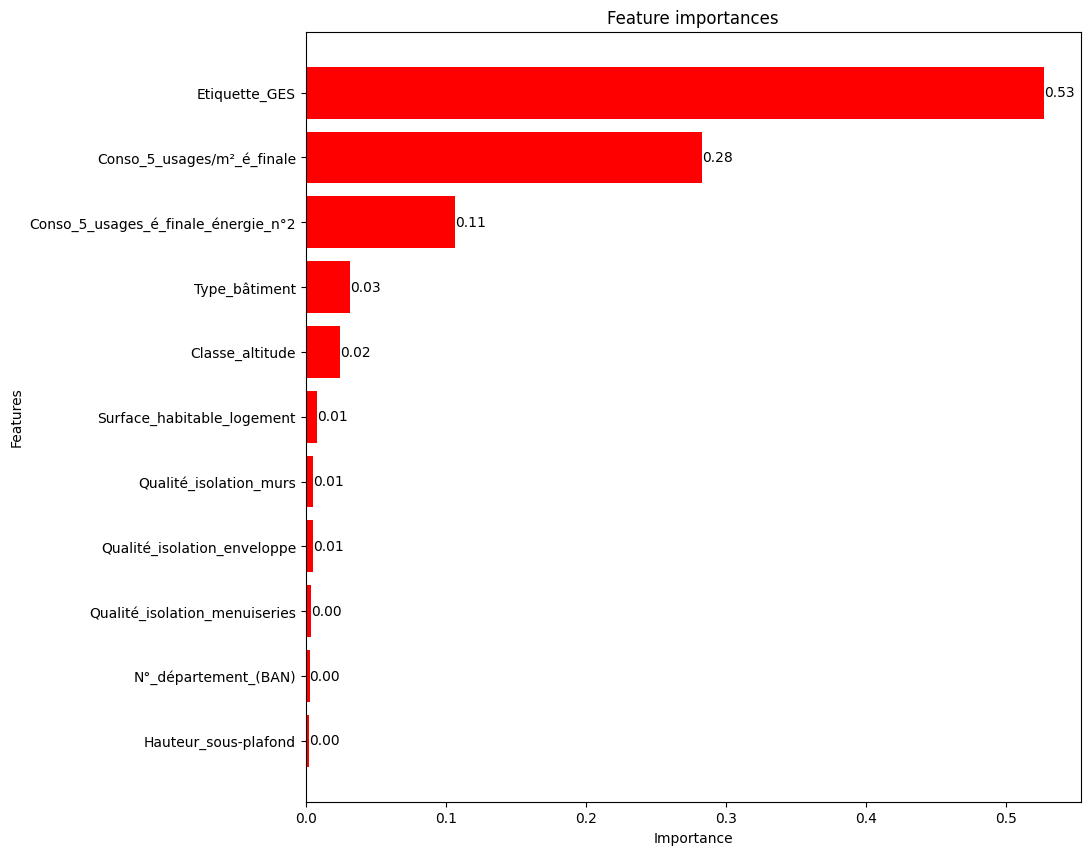

In [32]:
# Récupérer l'importance des caractéristiques
importances = model.feature_importances_

# Trier les caractéristiques par importance
indices = np.argsort(importances)[::-1]

# Afficher le classement des caractéristiques
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {X_train.columns[indices[f]]} ({importances[indices[f]]:.4f})")

# Tracer l'importance des caractéristiques dans un graphique à barres horizontales
plt.figure(figsize=(10, 10))
plt.title("Feature importances")
bars = plt.barh(range(X_train.shape[1]), importances[indices], color="r", align="center")

# Ajouter des étiquettes pour chaque barre
for bar in bars:
    plt.text(
        bar.get_width(),  # Position x de l'étiquette
        bar.get_y() + bar.get_height() / 2,  # Position y de l'étiquette
        f'{bar.get_width():.2f}',  # Valeur de l'étiquette
        va='center',  # Centrer verticalement
        ha='left'  # Aligner horizontalement à gauche
    )

plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
plt.gca().invert_yaxis()  # Inverser l'axe y
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()